In [3]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

from PIL import Image, ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A 
from albumentations.pytorch import ToTensorV2 
import cv2 

import os 
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import matplotlib.patches as patches 

from tqdm import tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cpu


### Utility Functions

In [7]:
def iou(box1, box2, is_pred=True): 
    if is_pred: 
        # IoU score for prediction and label 
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format 
          
        # Box coordinates of prediction 
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2
  
        # Box coordinates of ground truth 
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2
  
        # Get the coordinates of the intersection rectangle 
        x1 = torch.max(b1_x1, b2_x1) 
        y1 = torch.max(b1_y1, b2_y1) 
        x2 = torch.min(b1_x2, b2_x2) 
        y2 = torch.min(b1_y2, b2_y2) 
        # Make sure the intersection is at least 0 
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0) 
  
        # Calculate the union area 
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1)) 
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1)) 
        union = box1_area + box2_area - intersection 
  
        # Calculate the IoU score 
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon) 
  
        # Return IoU score 
        return iou_score 
      
    else: 
        # IoU score based on width and height of bounding boxes 
          
        # Calculate intersection area 
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * torch.min(box1[..., 1], box2[..., 1]) 
  
        # Calculate union area 
        box1_area = box1[..., 0] * box1[..., 1] 
        box2_area = box2[..., 0] * box2[..., 1] 
        union_area = box1_area + box2_area - intersection_area 
  
        # Calculate IoU score 
        iou_score = intersection_area / union_area 
  
        # Return IoU score 
        return iou_score

In [8]:
def nms(bboxes, iou_threshold, threshold): 
    # Filter out bounding boxes with confidence below the threshold. 
    bboxes = [box for box in bboxes if box[1] > threshold] 
  
    # Sort the bounding boxes by confidence in descending order. 
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) 
  
    # Initialize the list of bounding boxes after non-maximum suppression. 
    bboxes_nms = [] 
  
    while bboxes: 
        # Get the first bounding box. 
        first_box = bboxes.pop(0) 
  
        # Iterate over the remaining bounding boxes. 
        for box in bboxes: 
        # If the bounding boxes do not overlap or if the first bounding box has 
        # a higher confidence, then add the second bounding box to the list of 
        # bounding boxes after non-maximum suppression. 
            if box[0] != first_box[0] or iou( 
                torch.tensor(first_box[2:]), 
                torch.tensor(box[2:]), 
            ) < iou_threshold: 
                # Check if box is not in bboxes_nms 
                if box not in bboxes_nms: 
                    # Add box to bboxes_nms 
                    bboxes_nms.append(box) 
  
    # Return bounding boxes after non-maximum suppression. 
    return bboxes_nms

In [9]:
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True): 
    # Batch size used on predictions 
    batch_size = predictions.shape[0] 
    # Number of anchors 
    num_anchors = len(anchors) 
    # List of all the predictions 
    box_predictions = predictions[..., 1:5] 
  
    # If the input is predictions then we will pass the x and y coordinate 
    # through sigmoid function and width and height to exponent function and 
    # calculate the score and best class. 
    if is_predictions: 
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2) 
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) 
        box_predictions[..., 2:] = torch.exp( 
            box_predictions[..., 2:]) * anchors 
        scores = torch.sigmoid(predictions[..., 0:1]) 
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) 
      
    # Else we will just calculate scores and best class. 
    else: 
        scores = predictions[..., 0:1] 
        best_class = predictions[..., 5:6] 
  
    # Calculate cell indices 
    cell_indices = ( 
        torch.arange(s) 
        .repeat(predictions.shape[0], 3, s, 1) 
        .unsqueeze(-1) 
        .to(predictions.device) 
    ) 
  
    # Calculate x, y, width and height with proper scaling 
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices) 
    y = 1 / s * (box_predictions[..., 1:2] +
                 cell_indices.permute(0, 1, 3, 2, 4)) 
    width_height = 1 / s * box_predictions[..., 2:4] 
  
    # Concatinating the values and reshaping them in 
    # (BATCH_SIZE, num_anchors * S * S, 6) shape 
    converted_bboxes = torch.cat( 
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6) 
  
    # Returning the reshaped and converted bounding box list 
    return converted_bboxes.tolist()

In [10]:
 def plot_image(image, boxes): 
    # Getting the color map from matplotlib 
    colour_map = plt.get_cmap("tab20b") 
    # Getting 20 different colors from the color map for 20 different classes 
    colors = [colour_map(i) for i in np.linspace(0, 1, len(class_labels))] 
  
    # Reading the image with OpenCV 
    img = np.array(image) 
    # Getting the height and width of the image 
    h, w, _ = img.shape 
  
    # Create figure and axes 
    fig, ax = plt.subplots(1) 
  
    # Add image to plot 
    ax.imshow(img) 
  
    # Plotting the bounding boxes and labels over the image 
    for box in boxes: 
        # Get the class from the box 
        class_pred = box[0] 
        # Get the center x and y coordinates 
        box = box[2:] 
        # Get the upper left corner coordinates 
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
  
        # Create a Rectangle patch with the bounding box 
        rect = patches.Rectangle( 
            (upper_left_x * w, upper_left_y * h), 
            box[2] * w, 
            box[3] * h, 
            linewidth=2, 
            edgecolor=colors[int(class_pred)], 
            facecolor="none", 
        ) 
          
        # Add the patch to the Axes 
        ax.add_patch(rect) 
          
        # Add class name to the patch 
        plt.text( 
            upper_left_x * w, 
            upper_left_y * h, 
            s=class_labels[int(class_pred)], 
            color="white", 
            verticalalignment="top", 
            bbox={"color": colors[int(class_pred)], "pad": 0}, 
        ) 
  
    # Display the plot 
    plt.show()

In [11]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"): 
    print("==> Saving checkpoint") 
    checkpoint = { 
        "state_dict": model.state_dict(), 
        "optimizer": optimizer.state_dict(), 
    } 
    torch.save(checkpoint, filename)

In [12]:
def load_checkpoint(checkpoint_file, model, optimizer, lr): 
    print("==> Loading checkpoint") 
    checkpoint = torch.load(checkpoint_file, map_location=device) 
    model.load_state_dict(checkpoint["state_dict"]) 
    optimizer.load_state_dict(checkpoint["optimizer"]) 
  
    for param_group in optimizer.param_groups: 
        param_group["lr"] = lr 

In [13]:
# Device 
device = "cuda" if torch.cuda.is_available() else "cpu"
  
# Load and save model variable 
load_model = False
save_model = True
  
# model checkpoint file name 
checkpoint_file = "checkpoint.pth.tar"
  
# Anchor boxes for each feature map scaled between 0 and 1 
# 3 feature maps at 3 different scales based on YOLOv3 paper 
ANCHORS = [ 
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)], 
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)], 
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)], 
] 
  
# Batch size for training 
batch_size = 32
  
# Learning rate for training 
leanring_rate = 1e-5
  
# Number of epochs for training 
epochs = 30
  
# Image size 
image_size = 416
  
# Grid cell sizes 
s = [image_size // 32, image_size // 16, image_size // 8] 
  
# Class labels 
# class_labels = [ 
#     "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
#     "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", 
#     "pottedplant", "sheep", "sofa", "train", "tvmonitor", "Faces"
# ]

class_labels = [ 
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", 
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", 
    "pottedplant", "sheep", "sofa", "train", "tvmonitor", 'face'
]

In [14]:

# Create a dataset class to load the images and labels from the folder 
class Dataset(torch.utils.data.Dataset): 
    def __init__( 
        self, csv_file, image_dir, label_dir, anchors,  
        image_size=416, grid_sizes=[13, 26, 52], 
        num_classes=21, transform=None
    ): 
        # Read the csv file with image names and labels 
        self.label_list = pd.read_csv(csv_file) 
        # Image and label directories 
        self.image_dir = image_dir 
        self.label_dir = label_dir 
        # Image size 
        self.image_size = image_size 
        # Transformations 
        self.transform = transform 
        # Grid sizes for each scale 
        self.grid_sizes = grid_sizes 
        # Anchor boxes 
        self.anchors = torch.tensor( 
            anchors[0] + anchors[1] + anchors[2]) 
        # Number of anchor boxes  
        self.num_anchors = self.anchors.shape[0] 
        # Number of anchor boxes per scale 
        self.num_anchors_per_scale = self.num_anchors // 3
        # Number of classes 
        self.num_classes = num_classes 
        # Ignore IoU threshold 
        self.ignore_iou_thresh = 0.5
  
    def __len__(self): 
        return len(self.label_list) 
      
    def __getitem__(self, idx): 
        # Getting the label path 
        label_path = os.path.join(self.label_dir, self.label_list.iloc[idx, 1]) 
        # We are applying roll to move class label to the last column 
        # 5 columns: x, y, width, height, class_label 
        bboxes = np.roll(np.loadtxt(fname=label_path, 
                         delimiter=" ", ndmin=2), 4, axis=1).tolist() 
          
        # Getting the image path 
        img_path = os.path.join(self.image_dir, self.label_list.iloc[idx, 0]) 
        image = np.array(Image.open(img_path).convert("RGB")) 
  
        # Albumentations augmentations 
        if self.transform: 
            augs = self.transform(image=image, bboxes=bboxes) 
            image = augs["image"] 
            bboxes = augs["bboxes"] 
  
        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale 
        # target : [probabilities, x, y, width, height, class_label] 
        targets = [torch.zeros((self.num_anchors_per_scale, s, s, 6)) 
                   for s in self.grid_sizes] 
          
        # Identify anchor box and cell for each bounding box 
        for box in bboxes: 
            # Calculate iou of bounding box with anchor boxes 
            iou_anchors = iou(torch.tensor(box[2:4]),  
                              self.anchors,  
                              is_pred=False) 
            # Selecting the best anchor box 
            anchor_indices = iou_anchors.argsort(descending=True, dim=0) 
            x, y, width, height, class_label = box 
  
            # At each scale, assigning the bounding box to the  
            # best matching anchor box 
            has_anchor = [False] * 3
            for anchor_idx in anchor_indices: 
                scale_idx = anchor_idx // self.num_anchors_per_scale 
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale 
                  
                # Identifying the grid size for the scale 
                s = self.grid_sizes[scale_idx] 
                  
                # Identifying the cell to which the bounding box belongs 
                i, j = int(s * y), int(s * x) 
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0] 
                  
                # Check if the anchor box is already assigned 
                if not anchor_taken and not has_anchor[scale_idx]: 
  
                    # Set the probability to 1 
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
  
                    # Calculating the center of the bounding box relative 
                    # to the cell 
                    x_cell, y_cell = s * x - j, s * y - i  
  
                    # Calculating the width and height of the bounding box  
                    # relative to the cell 
                    width_cell, height_cell = (width * s, height * s) 
  
                    # Idnetify the box coordinates 
                    box_coordinates = torch.tensor( 
                                        [x_cell, y_cell, width_cell,  
                                         height_cell] 
                                    ) 
  
                    # Assigning the box coordinates to the target 
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates 
  
                    # Assigning the class label to the target 
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label) 
  
                    # Set the anchor box as assigned for the scale 
                    has_anchor[scale_idx] = True
  
                # If the anchor box is already assigned, check if the  
                # IoU is greater than the threshold 
                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh: 
                    # Set the probability to -1 to ignore the anchor box 
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1
  
        # Return the image and the target 
        return image, tuple(targets)

In [15]:
# Transform for training 
train_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Random color jittering 
        A.ColorJitter( 
            brightness=0.5, contrast=0.5, 
            saturation=0.5, hue=0.5, p=0.5
        ), 
        # Flip the image horizontally 
        A.HorizontalFlip(p=0.5), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ],  
    # Augmentation for bounding boxes 
    bbox_params=A.BboxParams( 
                    format="yolo",  
                    min_visibility=0.4,  
                    label_fields=[] 
                ) 
) 
  
# Transform for testing 
test_transform = A.Compose( 
    [ 
        # Rescale an image so that maximum side is equal to image_size 
        A.LongestMaxSize(max_size=image_size), 
        # Pad remaining areas with zeros 
        A.PadIfNeeded( 
            min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT 
        ), 
        # Normalize the image 
        A.Normalize( 
            mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255
        ), 
        # Convert the image to PyTorch tensor 
        ToTensorV2() 
    ], 
    # Augmentation for bounding boxes  
    bbox_params=A.BboxParams( 
                    format="yolo",  
                    min_visibility=0.4,  
                    label_fields=[] 
                ) 
)

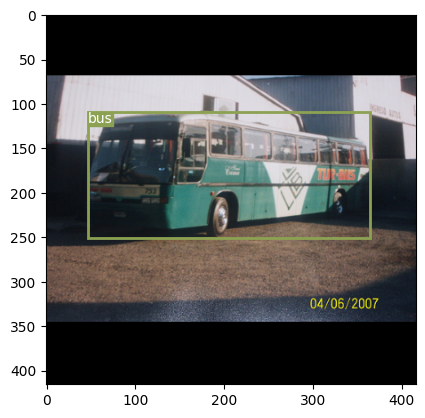

In [16]:
# Creating a dataset object 
dataset = Dataset( 
    csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv", 
    image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images", 
    label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels", 
    grid_sizes=[13, 26, 52], 
    anchors=ANCHORS, 
    transform=test_transform 
) 
  
# Creating a dataloader object 
loader = torch.utils.data.DataLoader( 
    dataset=dataset, 
    batch_size=1, 
    shuffle=True, 
) 
  
# Defining the grid size and the scaled anchors 
GRID_SIZE = [13, 26, 52] 
scaled_anchors = torch.tensor(ANCHORS) / ( 
    1 / torch.tensor(GRID_SIZE).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
) 
  
# Getting a batch from the dataloader 
x, y = next(iter(loader)) 
  
# Getting the boxes coordinates from the labels 
# and converting them into bounding boxes without scaling 
boxes = [] 
for i in range(y[0].shape[1]): 
    anchor = scaled_anchors[i] 
    boxes += convert_cells_to_bboxes( 
               y[i], is_predictions=False, s=y[i].shape[2], anchors=anchor 
             )[0] 
  
# Applying non-maximum suppression 
boxes = nms(boxes, iou_threshold=1, threshold=0.7) 
  
# Plotting the image with the bounding boxes 
plot_image(x[0].permute(1,2,0).to("cpu"), boxes)

In [17]:
class CNNBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, use_batch_norm=True, **kwargs): 
        super().__init__() 
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not use_batch_norm, **kwargs) 
        self.bn = nn.BatchNorm2d(out_channels) 
        self.activation = nn.LeakyReLU(0.1) 
        self.use_batch_norm = use_batch_norm 
  
    def forward(self, x): 
        # Applying convolution 
        x = self.conv(x) 
        # Applying BatchNorm and activation if needed 
        if self.use_batch_norm: 
            x = self.bn(x) 
            return self.activation(x) 
        else: 
            return x

In [18]:
class ResidualBlock(nn.Module): 
    def __init__(self, channels, use_residual=True, num_repeats=1): 
        super().__init__() 
          
        # Defining all the layers in a list and adding them based on number of  
        # repeats mentioned in the design 
        res_layers = [] 
        for _ in range(num_repeats): 
            res_layers += [ 
                nn.Sequential( 
                    nn.Conv2d(channels, channels // 2, kernel_size=1), 
                    nn.BatchNorm2d(channels // 2), 
                    nn.LeakyReLU(0.1), 
                    nn.Conv2d(channels // 2, channels, kernel_size=3, padding=1), 
                    nn.BatchNorm2d(channels), 
                    nn.LeakyReLU(0.1) 
                ) 
            ] 
        self.layers = nn.ModuleList(res_layers) 
        self.use_residual = use_residual 
        self.num_repeats = num_repeats 
      
    # Defining forward pass 
    def forward(self, x): 
        for layer in self.layers: 
            residual = x 
            x = layer(x) 
            if self.use_residual: 
                x = x + residual 
        return x

In [19]:
class ScalePrediction(nn.Module): 
    def __init__(self, in_channels, num_classes): 
        super().__init__() 
        # Defining the layers in the network 
        self.pred = nn.Sequential( 
            nn.Conv2d(in_channels, 2*in_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(2*in_channels), 
            nn.LeakyReLU(0.1), 
            nn.Conv2d(2*in_channels, (num_classes + 5) * 3, kernel_size=1), 
        ) 
        self.num_classes = num_classes 
      
    # Defining the forward pass and reshaping the output to the desired output  
    # format: (batch_size, 3, grid_size, grid_size, num_classes + 5) 
    def forward(self, x): 
        output = self.pred(x) 
        output = output.view(x.size(0), 3, self.num_classes + 5, x.size(2), x.size(3)) 
        output = output.permute(0, 1, 3, 4, 2) 
        return output

In [20]:
class YOLOv3(nn.Module): 
    def __init__(self, in_channels=3, num_classes=21): 
        super().__init__() 
        self.num_classes = num_classes 
        self.in_channels = in_channels 
  
        # Layers list for YOLOv3 
        self.layers = nn.ModuleList([ 
            CNNBlock(in_channels, 32, kernel_size=3, stride=1, padding=1), 
            CNNBlock(32, 64, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(64, num_repeats=1), 
            CNNBlock(64, 128, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(128, num_repeats=2), 
            CNNBlock(128, 256, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(256, num_repeats=8), 
            CNNBlock(256, 512, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(512, num_repeats=8), 
            CNNBlock(512, 1024, kernel_size=3, stride=2, padding=1), 
            ResidualBlock(1024, num_repeats=4), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(1024, use_residual=False, num_repeats=1), 
            CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(512, num_classes=num_classes), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(768, 256, kernel_size=1, stride=1, padding=0), 
            CNNBlock(256, 512, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(512, use_residual=False, num_repeats=1), 
            CNNBlock(512, 256, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(256, num_classes=num_classes), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            nn.Upsample(scale_factor=2), 
            CNNBlock(384, 128, kernel_size=1, stride=1, padding=0), 
            CNNBlock(128, 256, kernel_size=3, stride=1, padding=1), 
            ResidualBlock(256, use_residual=False, num_repeats=1), 
            CNNBlock(256, 128, kernel_size=1, stride=1, padding=0), 
            ScalePrediction(128, num_classes=num_classes) 
        ]) 
      
    # Forward pass for YOLOv3 with route connections and scale predictions 
    def forward(self, x): 
        outputs = [] 
        route_connections = [] 
  
        for layer in self.layers: 
            if isinstance(layer, ScalePrediction): 
                outputs.append(layer(x)) 
                continue
            x = layer(x) 
  
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8: 
                route_connections.append(x) 
              
            elif isinstance(layer, nn.Upsample): 
                x = torch.cat([x, route_connections[-1]], dim=1) 
                route_connections.pop() 
        return outputs

In [21]:
if __name__ == "__main__": 
    # Setting number of classes and image size 
    num_classes = 21
    IMAGE_SIZE = 416
  
    # Creating model and testing output shapes 
    model = YOLOv3(num_classes=num_classes) 
    x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE)) 
    out = model(x) 
    print(out[0].shape) 
    print(out[1].shape) 
    print(out[2].shape) 
  
    # Asserting output shapes 
    assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
    assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
    assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
    print("Output shapes are correct!")

torch.Size([1, 3, 13, 13, 26])
torch.Size([1, 3, 26, 26, 26])
torch.Size([1, 3, 52, 52, 26])
Output shapes are correct!


In [22]:
class YOLOLoss(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.mse = nn.MSELoss() 
        self.bce = nn.BCEWithLogitsLoss() 
        self.cross_entropy = nn.CrossEntropyLoss() 
        self.sigmoid = nn.Sigmoid() 
      
    def forward(self, pred, target, anchors): 
        # Identifying which cells in target have objects  
        # and which have no objects 
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0
  
        # Calculating No object loss 
        no_object_loss = self.bce( 
            (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]), 
        ) 
  
          
        # Reshaping anchors to match predictions 
        anchors = anchors.reshape(1, 3, 1, 1, 2) 
        # Box prediction confidence 
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]), 
                               torch.exp(pred[..., 3:5]) * anchors 
                            ],dim=-1) 
        # Calculating intersection over union for prediction and target 
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach() 
        # Calculating Object loss 
        object_loss = self.mse(self.sigmoid(pred[..., 0:1][obj]), 
                               ious * target[..., 0:1][obj]) 
  
          
        # Predicted box coordinates 
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3]) 
        # Target box coordinates 
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors) 
        # Calculating box coordinate loss 
        box_loss = self.mse(pred[..., 1:5][obj], 
                            target[..., 1:5][obj]) 
  
          
        # Claculating class loss 
        class_loss = self.cross_entropy((pred[..., 5:][obj]), 
                                   target[..., 5][obj].long()) 
  
        # Total loss 
        return ( 
            box_loss 
            + object_loss 
            + no_object_loss 
            + class_loss 
        )

In [23]:
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors): 
    # Creating a progress bar 
    progress_bar = tqdm(loader, leave=True) 
  
    # Initializing a list to store the losses 
    losses = [] 
  
    # Iterating over the training data 
    for _, (x, y) in enumerate(progress_bar): 
        x = x.to(device) 
        y0, y1, y2 = ( 
            y[0].to(device), 
            y[1].to(device), 
            y[2].to(device), 
        ) 
  
        with torch.cuda.amp.autocast(): 
            # Getting the model predictions 
            outputs = model(x) 
            # Calculating the loss at each scale 
            loss = ( 
                  loss_fn(outputs[0], y0, scaled_anchors[0]) 
                + loss_fn(outputs[1], y1, scaled_anchors[1]) 
                + loss_fn(outputs[2], y2, scaled_anchors[2]) 
            ) 
  
        # Add the loss to the list 
        losses.append(loss.item()) 
  
        # Reset gradients 
        optimizer.zero_grad() 
  
        # Backpropagate the loss 
        scaler.scale(loss).backward() 
  
        # Optimization step 
        scaler.step(optimizer) 
  
        # Update the scaler for next iteration 
        scaler.update() 
  
        # update progress bar with loss 
        mean_loss = sum(losses) / len(losses) 
        progress_bar.set_postfix(loss=mean_loss)
        
    return mean_loss

In [69]:
# model = YOLOv3().to(device) 
  
# # Defining the optimizer 
# optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
  
# # Defining the loss function 
# loss_fn = YOLOLoss() 
  
# # Defining the scaler for mixed precision training 
# scaler = torch.cuda.amp.GradScaler() 
  
# # Defining the train dataset 
# train_dataset = Dataset( 
#     csv_file="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv", 
#     image_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images", 
#     label_dir="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels",
#     anchors=ANCHORS, 
#     transform=train_transform 
# ) 
  
# # Defining the train data loader 
# train_loader = torch.utils.data.DataLoader( 
#     train_dataset, 
#     batch_size = batch_size, 
#     num_workers = 2, 
#     shuffle = True, 
#     pin_memory = True, 
# ) 
  
# # Scaling the anchors 
# scaled_anchors = ( 
#     torch.tensor(ANCHORS) * 
#     torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
# ).to(device) 
  
# history = [] 
# # for e in range(1, epochs+1): 
# for e in range(1, 1+1): 
#     print("Epoch:", e) 
#     loss = training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 
#     history.append(loss)
  
#     # Saving the model 
#     if save_model: 
#         save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")


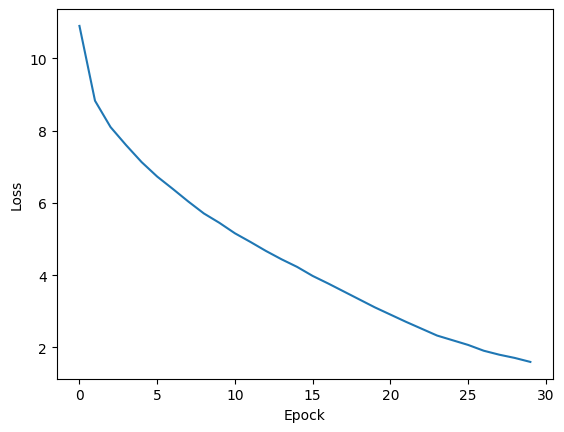

In [1]:
import matplotlib.pyplot as plt
# save the losses we got manually to make it easier for use
lossesss = [10.9, 8.83, 8.1, 7.6, 7.13, 6.73, 6.39, 6.04, 5.71, 5.45, 5.16, 4.92,4.67, 4.44, 4.23, 3.98, 3.77, 3.55,
 3.33, 3.11, 2.91, 2.71, 2.52, 2.33, 2.2, 2.07, 1.91,1.8, 1.71, 1.6]

try:
    plt.plot(history)
except NameError:
    plt.plot(lossesss)
plt.ylabel('Loss')
plt.xlabel('Epock')
plt.show()


In [71]:
# transfer learning
import os
import pandas as pd
im = "/kaggle/input/obj-train-dat/data"
lab = '/kaggle/input/data-faces/obj_train_data'
trainimgs ="/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/train.csv"

imagess = [i for i in os.listdir(im)]
labelss = [f'{i.split(".")[0]}.txt' for i in imagess]
dictionary = {'img':imagess, 'label':labelss }

obj_train_data_dataframe = pd.DataFrame(dictionary)
tar = pd.read_csv(trainimgs)
tar.columns =['img','label']
combined = pd.concat([tar,obj_train_data_dataframe], axis =0)

combined.to_csv('faceimages_combined.csv', index = False)

obj_train_data_dataframe
combined

,img,label
0,000007.jpg,000007.txt
1,000009.jpg,000009.txt
2,000016.jpg,000016.txt
3,000019.jpg,000019.txt
4,000020.jpg,000020.txt
...,...,...
16,p1125783_53587890477_o.jpg,p1125783_53587890477_o.txt
17,p1125708_53588966978_o.jpg,p1125708_53588966978_o.txt
18,p1125723_53589202095_o.jpg,p1125723_53589202095_o.txt
19,p1125785_53587889687_o.jpg,p1125785_53587889687_o.txt


In [72]:
# Source directory containing the first set of image files
import os
import shutil

source_directory1 = '/kaggle/input/obj-train-dat/data'

# Source directory containing the second set of image files
source_directory2 = '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images'

# Destination directory in the Kaggle working directory
destination_directory = '/kaggle/working/joined_images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# List files in the source directories
image_files1 = [file for file in os.listdir(source_directory1) if file.endswith('.jpg')]
image_files2 = [file for file in os.listdir(source_directory2) if file.endswith('.jpg')]

# Copy image files from the first source directory to the destination directory
for file in image_files1:
    source_path = os.path.join(source_directory1, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copyfile(source_path, destination_path)

# Copy image files from the second source directory to the destination directory
for file in image_files2:
    source_path = os.path.join(source_directory2, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copyfile(source_path, destination_path)

print("Images joined and saved in:", destination_directory)

Images joined and saved in: /kaggle/working/joined_images


In [73]:
# Source directory containing the first set of image files
import os
import shutil

# source_directory1 = '/kaggle/input/obj-train-dat/obj_train_data/obj_train_data'
source_directory1 = '/kaggle/input/data-faces/obj_train_data'

# Source directory containing the second set of image files
source_directory2 = '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/labels'
# Destination directory in the Kaggle working directory
destination_directory = '/kaggle/working/joined_labes'

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# List files in the source directories
image_files1 = [file for file in os.listdir(source_directory1) if file.endswith('.txt')]
image_files2 = [file for file in os.listdir(source_directory2) if file.endswith('.txt')]

# Copy image files from the first source directory to the destination directory
for file in image_files1:
    source_path = os.path.join(source_directory1, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copyfile(source_path, destination_path)

# Copy image files from the second source directory to the destination directory
for file in image_files2:
    source_path = os.path.join(source_directory2, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copyfile(source_path, destination_path)

print("Images joined and saved in:", destination_directory)

Images joined and saved in: /kaggle/working/joined_labes


In [74]:
model = YOLOv3().to(device) 
  
# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler() 
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file='/kaggle/working/faceimages_combined.csv', 
    image_dir= '/kaggle/working/joined_images', 
    label_dir= '/kaggle/working/joined_labes',
    anchors=ANCHORS, 
    transform=train_transform 
) 
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True, 
) 
  
# Scaling the anchors 
scaled_anchors = ( 
    torch.tensor(ANCHORS) * 
    torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 
  
history = [] 
# for e in range(1, epochs+1): 
for e in range(1, 1+1): 
    print("Epoch:", e) 
    loss = training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 
    history.append(loss)
  
    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint2.pth.tar")


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import wandb
import pandas as pd

# Assuming your DataFrame is named shuffled_df
shuffled_df = pd.read_csv('/kaggle/working/faceimages.csv')  # Load your DataFrame

# Initialize wandb with your project and experiment name
wandb.init(project='your_project_name', name='your_experiment_name')

# Log your DataFrame to wandb
wandb.log({"shuffled_data": wandb.Table(dataframe=shuffled_df)})

# Check for device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Save your DataFrame to wandb
shuffled_df.to_csv('/kaggle/working/faceimages.csv')  # Save your DataFrame
wandb.save('/kaggle/working/faceimages.csv')  # Save the file to wandb

# Finish the wandb run
wandb.finish()


In [ ]:
    import cv2
    import matplotlib.pyplot as plt

    # Initialize the camera
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Error: Could not open camera.")
        exit()

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Check if the frame is valid
        if not ret:
            print("Error: Could not capture frame.")
            break

        # Display the captured frame
        plt.imshow(frame)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        # save the image
        cv2.imwrite("image.jpg", frame)
        print("Image saved as image.jpg")
        # Break the loop
        break

    # Release the camera
    cap.release()


In [ ]:
import cv2
for i in range(10):  # Try up to 10 cameras
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera with index {i} is opened.")
        cap.release()
    else:
        print(f"Camera with index {i} is not opened.")


In [ ]:
# Source directory containing the first set of image files
import os
import shutil

source_directory1 = '/kaggle/input/obj-train-dat/data'

# Source directory containing the second set of image files
source_directory2 = '/kaggle/input/pascal-voc-dataset-used-in-yolov3-video/PASCAL_VOC/images'

# Destination directory in the Kaggle working directory
destination_directory = '/kaggle/working/joined_images'

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# List files in the source directories
image_files1 = [file for file in os.listdir(source_directory1) if file.endswith('.jpg')]
image_files2 = [file for file in os.listdir(source_directory2) if file.endswith('.jpg')]

# Copy image files from the first source directory to the destination directory
for file in image_files1:
    source_path = os.path.join(source_directory1, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copyfile(source_path, destination_path)

# Copy image files from the second source directory to the destination directory
for file in image_files2:
    source_path = os.path.join(source_directory2, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copyfile(source_path, destination_path)

print("Images joined and saved in:", destination_directory)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import tarfile
import os

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 21  # Change this to the number of classes in your dataset
NUM_EPOCHS = 30  # Adjust as needed
DATASET_DIR = '/kaggle/input/your_dataset'  # Path to your dataset
MODEL_PATH = '/kaggle/working/checkpoint.pth.tar'  # Path to your model .tar file

# Extract the model files from the .tar archive
with tarfile.open(MODEL_PATH, 'r') as tar:
    tar.extractall('/kaggle/working')

# Load the model
model = load_model('/kaggle/working/checkpoint.pth.tar')  # Adjust the model filename if necessary

# Freeze base model layers
for layer in model.layers[0].layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Splitting data into training and validation

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),  # Path to training images
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),  # Path to training images
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Save the trained model
model.save('/kaggle/working/fine_tuned_model.h5')
